In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:

# Téléchargement du dataset ESC-50
%cd /content
!git clone https://github.com/karolpiczak/ESC-50.git

meta_csv = "/content/ESC-50/meta/esc50.csv"
metadata = pd.read_csv(meta_csv)



/content
Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4199 (delta 62), reused 34 (delta 34), pack-reused 4130 (from 1)
Receiving objects: 100% (4199/4199), 878.77 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Updating files: 100% (2011/2011), done.


In [26]:
# === Téléchargement et extraction des tokens (si besoin) ===
import os

zip_path = "/content/esc50_tokens_WavTokenizer_large_speech.zip"

if not os.path.exists("/content/esc50_tokens_WavTokenizer_large_speech"):
    if not os.path.exists(zip_path):
        !wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer_large_speech.zip -O {zip_path}
    !unzip {zip_path} -d /content/

# === Lecture des métadonnées ===
meta_csv = "/content/ESC-50/meta/esc50.csv"
metadata = pd.read_csv(meta_csv)

# === Chargement des tokens filtrés ===
tokens_dir_ls = '/content/esc50_tokens_WavTokenizer_large_speech'
filenames_list = sorted([f for f in os.listdir(tokens_dir_ls) if f.endswith('.pt')])

file_data_list_ls = []

for fname in tqdm(filenames_list):
    tok_path = os.path.join(tokens_dir_ls, fname)

    try:
        tokens = torch.load(tok_path)
    except Exception as e:
        print(f"Erreur lors du chargement de {fname} : {e}")
        continue

    # --- Filtrage du silence (token 470) ---
    filtered_tokens = tokens[tokens != 470]

    # On ignore les fichiers contenant uniquement du silence
    if filtered_tokens.numel() == 0:
        continue

    # Ajout dans la liste
    file_data_list_ls.append({
        'filename': fname,
        'tokens': filtered_tokens.tolist(),
        'gt_category': metadata.loc[metadata['filename'] == fname.replace('.pt', '.wav'), 'category'].values[0]
    })

print(f"Nombre de fichiers conservés après filtrage : {len(file_data_list_ls)}")


100%|██████████| 2000/2000 [00:02<00:00, 786.08it/s]

Nombre de fichiers conservés après filtrage : 2000


In [27]:
# Création de la liste de documents sous forme d'histogrammes
token_counters = []
gt_labels = []

# On parcourt les fichiers déjà filtrés
for file_data in file_data_list_ls:
    token_ids = file_data["tokens"]
    token_counts = Counter(token_ids)  # Histogramme: {token_id: count}
    token_counters.append(token_counts)
    gt_labels.append(file_data["gt_category"])

print("Histogrammes construits pour", len(token_counters), "fichiers.")


Histogrammes construits pour 2000 fichiers.


In [28]:
# 1. Transformation des histogrammes en matrice count (dense)
dict_vectorizer = DictVectorizer(sparse=False)
count_matrix = dict_vectorizer.fit_transform(token_counters)  # shape: (n_samples, n_tokens)

# 2. Application du TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(count_matrix).toarray()  # shape: (n_samples, n_tokens)

print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (2000, 3978)


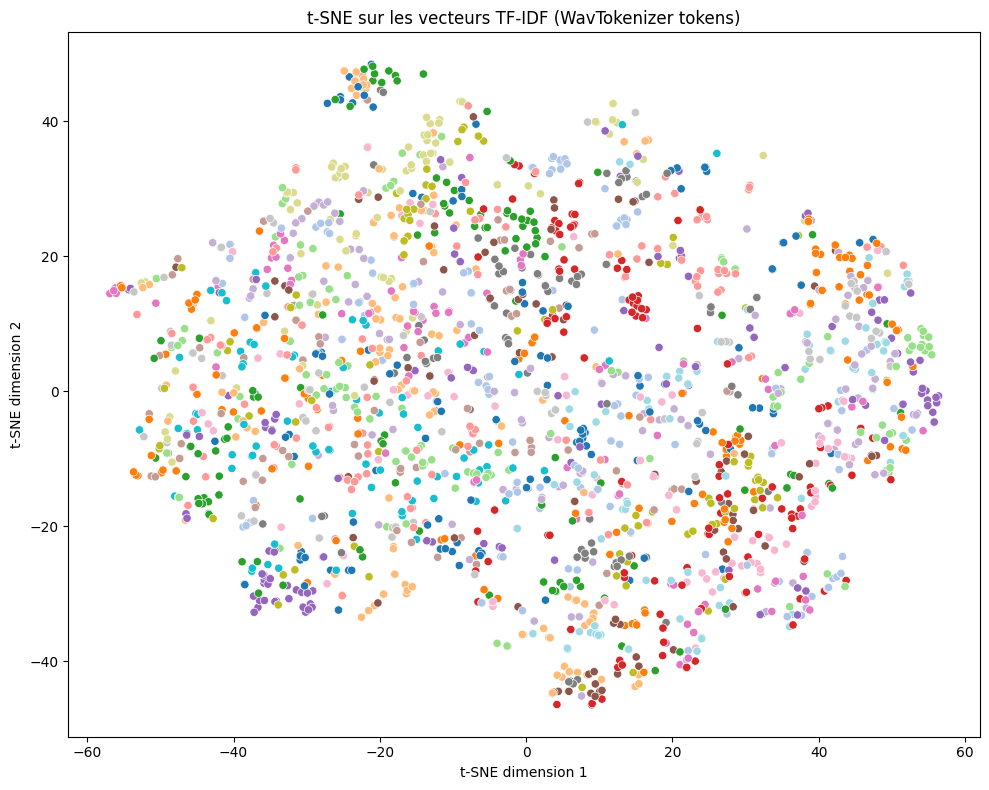

In [29]:
# Réduction dimensionnelle avec PCA (facilite t-SNE)
pca = PCA(n_components=50, random_state=42)
reduced = pca.fit_transform(tfidf_matrix)

# t-SNE pour visualisation en 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(reduced)

# Affichage
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=gt_labels, palette='tab20', legend=False)
plt.title("t-SNE sur les vecteurs TF-IDF (WavTokenizer tokens)")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.tight_layout()
plt.show()


In [36]:

n_clusters = 10  # ESC-50 contient 50 classes, mais on peut tester avec 10 pour explorer
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(tfidf_matrix)

print("KMeans clustering terminé. Nombre de clusters:", len(set(cluster_labels_kmeans)))



KMeans clustering terminé. Nombre de clusters: 10


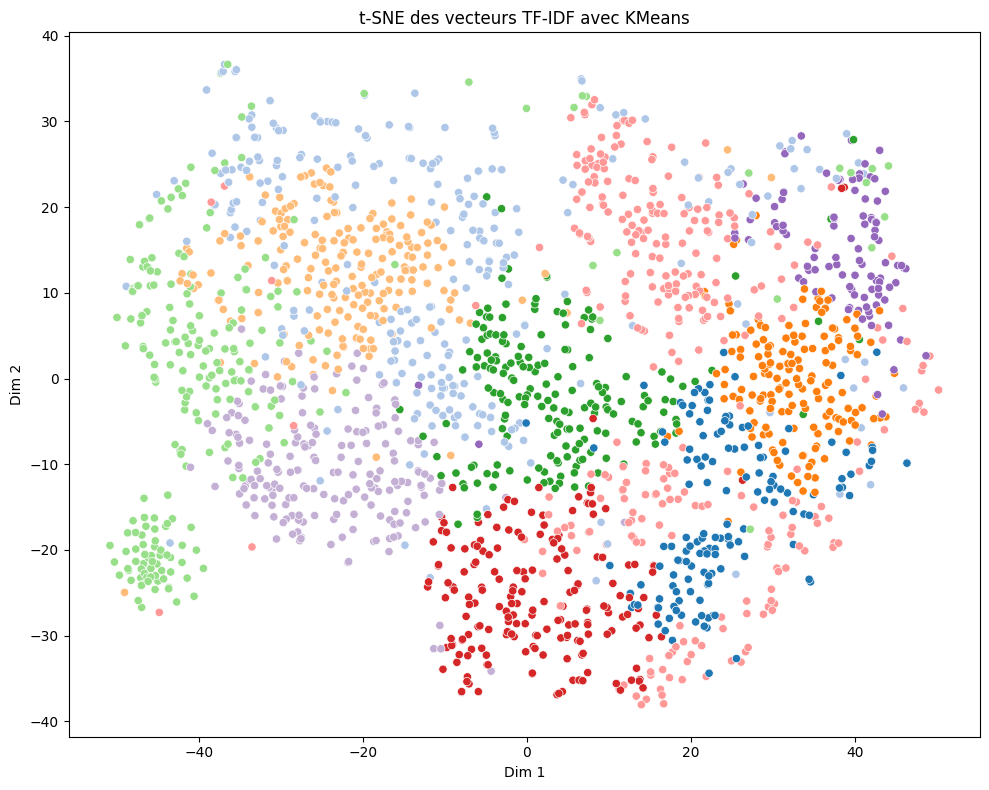

In [37]:
# Réduction de dimension (optionnel mais conseillé)
tsne_kmeans = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result_kmeans = tsne_kmeans.fit_transform(tfidf_matrix)

# Visualisation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result_kmeans[:, 0], y=tsne_result_kmeans[:, 1], hue=cluster_labels_kmeans, palette='tab20', legend=False)
plt.title("t-SNE des vecteurs TF-IDF avec KMeans")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()
